# Read Data Set 

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import database as db
import os

pd.set_option('display.max_rows', 200)

# Data Parameters
data_path  = './data'
instrument = 'EG'
date       = '20210105'

# Read CSV Data

df = pd.read_csv(data_path + os.sep + instrument + os.sep + date + '.csv', index_col=0, parse_dates=True)
df['MidPrice'] = 0.5* (df['BidPrice1'] + df['AskPrice1'])
display(df)

,InstrumentID,TradingDay,PreClosePrice,Volume,Turnover,OpenInterest,LastPrice,BidPrice1,BidVolume1,AskPrice1,AskVolume1,MidPrice
datetime,,,,,,,,,,,,
2021-01-04 21:00:01.570,eg2105,20210105,4503.0,3057,137119830,257978,4489.0,4489.0,3,4492.0,10,4490.5
2021-01-04 21:00:02.530,eg2105,20210105,4503.0,3126,140218460,258022,4492.0,4492.0,1,4493.0,5,4492.5
2021-01-04 21:00:02.578,eg2105,20210105,4503.0,3424,153599200,257955,4492.0,4489.0,69,4492.0,11,4490.5
2021-01-04 21:00:03.680,eg2105,20210105,4503.0,3493,156698310,257970,4491.0,4490.0,15,4492.0,2,4491.0
2021-01-04 21:00:04.590,eg2105,20210105,4503.0,3643,163432980,257997,4490.0,4488.0,1,4490.0,53,4489.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-05 14:59:57.512,eg2105,20210105,4503.0,291888,13031404950,244678,4419.0,4419.0,50,4420.0,2,4419.5
2021-01-05 14:59:58.380,eg2105,20210105,4503.0,291900,13031935250,244679,4419.0,4419.0,40,4421.0,5,4420.0
2021-01-05 14:59:58.560,eg2105,20210105,4503.0,291905,13032156260,244679,4421.0,4419.0,43,4421.0,2,4420.0


# Test Database

In [2]:
%reload_ext autoreload
%autoreload 2

import database as db

print(db.GetTickSize(instrument))
print(db.GetContractSize(instrument))
#print(db.GetTradeDates(instrument))
print(len(db.GetTradeDates(instrument))) # Number of tradeDates in 2021
print(db.GetSecond(df.index))

1
10
224
[0.0000000e+00 9.6000000e-01 1.0080000e+00 ... 2.0693990e+04 2.0695230e+04
 2.0695383e+04]


# Class: Backtest

,Instrument,Period,Freq,Exchange Rebate,Broker Rebate,slippage
Value,EG,20210201 - 20210330,15min,0.1,0.1,3 ticks


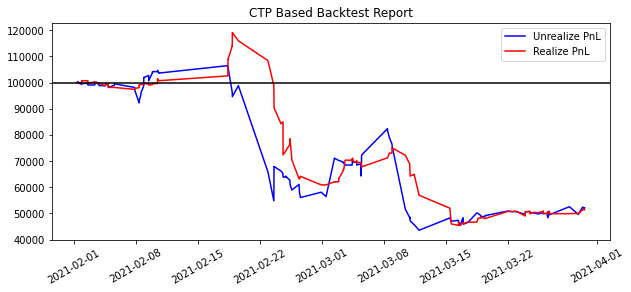

,开多,开空,减多,减空,反开,反空,平开,平空,全平
Actions,54,54,52,53,14,18,0,0,0


,Ticks Modelled,Initial Capital,Final Capital,Realized PnL,Return,MaxDrawdown,MaxDrawdown Ratio,Win Rate,Win Rate (Long),Win Rate (Short),PnL Ratio,PnL Ratio (Long),PnL Ratio (Short),EPO,EPO (Long),EPO (Short)
Stats,1345007,100000,51414.39,-48585.61,-48.6,73703.78,0.62,0.56,0.52,0.6,0.58,0.99,0.35,-458.64,-5.89,-902.84


In [3]:
%reload_ext autoreload
%autoreload 2

from backtest2 import backtest
import pandas as pd
import numpy as np
import database as db
import helpers
import metrics
import os
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

data_path = './data'
start_date = '20210201'
end_date = '20210330'
instrument = 'EG'
freq = '15min'
dates = np.array(db.GetTradeDates(instrument))
dates = dates[np.where((dates >= start_date) & (dates <= end_date))]
slippage = 3
capital = 100000
acc_id = '00001'
broker_rate = 1
ex_rebate = 0.10
br_rebate = 0.10

args = (instrument, slippage, acc_id, capital, broker_rate, ex_rebate, br_rebate)
bt = backtest(*args)
ff = pd.read_csv(f'./feature/{instrument}_feature_{freq}.csv', index_col=0, parse_dates=True)
for date in dates:
    # Load Feature
    f = ff[ff.TradeDate == int(date)]
    f[['lower', 'mid', 'upper', 'rsi']] = f[['BBL_14_2.0', 'BBM_14_2.0', 'BBU_14_2.0', 'RSI_6']]
    f['sigl'] = np.where((f.close <  f.lower) & (f.rsi <  20)                ,  0,
                np.where((f.close >  f.upper) & (f.rsi >  80)                ,  5,
                np.where((f.close <= f.lower) & (f.rsi >= 20) & (f.rsi <= 50),  0,
                np.where((f.close >= f.upper) & (f.rsi >= 50) & (f.rsi <= 80),  1, 
                np.where((f.close >  f.mid  ) & (f.last_close <  f.mid)      ,  1,
                np.where((f.close <  f.mid  ) & (f.last_close >  f.mid)      ,  3,
                0))))))
    f['sigs'] = np.where((f.close <  f.lower) & (f.rsi <  20)                , -5,
                np.where((f.close >  f.upper) & (f.rsi >  80)                ,  0,
                np.where((f.close <= f.lower) & (f.rsi >= 20) & (f.rsi <= 50), -1,
                np.where((f.close >= f.upper) & (f.rsi >= 50) & (f.rsi <= 80),  0, 
                np.where((f.close >  f.mid  ) & (f.last_close <  f.mid)      , -3,
                np.where((f.close <  f.mid  ) & (f.last_close >  f.mid)      , -1,
                0))))))
    # Load Bktest dateframe
    df = pd.read_csv(data_path + os.sep + instrument + os.sep + date + '.csv', index_col=0, parse_dates=True)
    df['MidPrice'] = 0.5* (df['BidPrice1'] + df['AskPrice1'])
    temp = pd.merge_asof(df.index.to_frame().set_index('datetime'), f[['sigl', 'sigs']], left_index=True, right_index=True, direction='backward', tolerance=pd.Timedelta('30s'))
    df['sigl'] = helpers.SignalFilter(temp['sigl'].values)
    df['sigs'] = helpers.SignalFilter(temp['sigs'].values)
    bt.run(df)
    
par = pd.DataFrame({
    'Instrument': instrument,
    'Period': '{} - {}'.format(start_date, end_date),
    'Freq': freq,
    'Exchange Rebate': ex_rebate,
    'Broker Rebate': br_rebate,
    'slippage': '{} ticks'.format(slippage)
}, index=['Value'])
display(par)

res = bt.result()
res.set_index('datetime', inplace=True)
fig = plt.figure(figsize=(10, 4))
plt.plot(res['total_pnl'], '-', color='blue', label='Unrealize PnL')
plt.plot(res['total_rpnl'], '-', color='red', label='Realize PnL')
plt.axhline(y=bt.capital, color='black', linestyle='-')
plt.xticks(rotation=30)
plt.title('CTP Based Backtest Report')
plt.legend()
plt.show()

counts = metrics.GetCounts(res)
display(counts)

acc = metrics.GetAccount(res, int(bt.ticks), bt.capital)
display(acc)


# Settlement Report

In [4]:
res = bt.result()
res.set_index(['datetime', 'order_id']).head()

account_id    code   price direction action  \
datetime                order_id                                               
2021-02-01 10:00:00.387 2             00001  eg2105  4669.0         空      开   
2021-02-01 10:45:00.304 3             00001  eg2105  4665.0         空      开   
2021-02-01 11:00:00.448 4             00001  eg2105  4647.0         空      开   
2021-02-01 14:45:00.230 5             00001  eg2105  4667.0         多      开   
                        5             00001  eg2105  4667.0         空     减今   

                                  volume    value  ex_fee  total_fee  lpos  \
datetime                order_id                                             
2021-02-01 10:00:00.387 2              1  46720.0     3.0       3.97     0   
2021-02-01 10:45:00.304 3              1  46680.0     3.0       3.97     0   
2021-02-01 11:00:00.448 4              1  46500.0     3.0       3.97     0   
2021-02-01 14:45:00.230 5              1  46640.0     3.0       3.97     1   
                        5              1  46640.0     3.0       3.97     1   

                                  spos  total_pos  u_pnl  r_pnl  total_pnl  \
datetime                order_id                                             
2021-02-01 10:00:00.387 2            1          1    0.0  -3.97   99996.03   
2021-02-01 10:45:00.304 3            2          2   40.0  -3.97  100032.06   
2021-02-01 11:00:00.448 4            3          3  400.0  -3.97  100388.09   
2021-02-01 14:45:00.230 5            3          4 -200.0  -3.97   99784.12   
                        5            2          3 -220.0  16.03   99780.15   

                                  total_rpnl  
datetime                order_id              
2021-02-01 10:00:00.387 2           99996.03  
2021-02-01 10:45:00.304 3           99992.06  
2021-02-01 11:00:00.448 4           99988.09  
2021-02-01 14:45:00.230 5           99984.12  
                        5          100000.15

# Report Visualization (Zoom In/Out)

In [5]:
import utils
f = pd.read_csv(f'./feature/{instrument}_feature_{freq}.csv', index_col=0, parse_dates=True)
f = f[(f.TradeDate >= int(start_date)) & (f.TradeDate <= int(end_date))]
res = bt.result()
res.index = pd.to_datetime(res['datetime'].dt.strftime('%Y-%m-%d %H:%M'))
df = pd.merge(f, res, left_index=True, right_index=True, how='outer', suffixes=('', '_1'))
df['total_pnl'].iloc[0] = bt.capital
fig = utils.GetVisual(df, freq)
fig.show()

In [6]:
f

,open,high,low,close,volume,Contract,TradeDate,PreClose,last_close,RSI_6,RSI_14,RSI_50,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
datetime,,,,,,,,,,,,,,,,,
2021-01-31 21:15:00,4691.0,4737.0,4676.5,4722.5,54516.0,eg2105,20210201,4659.0,4658.0,88.750018,83.921654,70.968529,4525.780223,4619.964286,4714.148349,4.077264,1.044337
2021-01-31 21:30:00,4722.5,4722.5,4683.5,4687.5,28028.0,eg2105,20210201,4659.0,4722.5,66.971887,71.800987,67.020468,4536.193554,4629.321429,4722.449303,4.023392,0.812359
2021-01-31 21:45:00,4687.5,4695.0,4659.5,4667.0,31906.0,eg2105,20210201,4659.0,4687.5,57.120232,65.805997,64.863815,4554.946323,4637.857143,4720.767963,3.575393,0.675748
2021-01-31 22:00:00,4667.5,4677.0,4658.5,4663.0,15279.0,eg2105,20210201,4659.0,4667.0,55.218333,64.671350,64.450880,4573.962103,4645.250000,4716.537897,3.069281,0.624495
2021-01-31 22:15:00,4662.5,4683.5,4662.5,4679.5,12868.0,eg2105,20210201,4659.0,4663.0,61.554769,67.184847,65.378610,4594.164521,4653.178571,4712.192622,2.536505,0.723010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30 14:00:00,5050.5,5068.5,5044.5,5065.0,13623.0,eg2105,20210330,4951.0,5050.5,55.443631,55.756596,51.428196,5012.718662,5057.750000,5102.781338,1.780687,0.580499
2021-03-30 14:15:00,5064.5,5081.5,5063.5,5076.5,9070.0,eg2105,20210330,4951.0,5065.0,61.177940,58.029791,52.052572,5024.565848,5062.392857,5100.219867,1.494432,0.686469
2021-03-30 14:30:00,5076.5,5084.5,5064.5,5065.5,8181.0,eg2105,20210330,4951.0,5076.5,53.303762,55.112896,51.407575,5035.264407,5065.535714,5095.807022,1.195187,0.499410
